In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-ultrasound-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209633%2F2021025%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240317%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240317T102828Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D96885be9517c23afde6b5766c6b76c59a4373c58a467b3f61c94f42474dded4ad22381064aa52e5f4696a3e32650493908976fff012660d8d2f445071e1c60a17b8136ec7fd0b46e751c2e7c2cc713c2db2993b4682036646706aeebc2094b4849efeb4c37101f70b2db285dc947f3016a924b4ec4e1785fd7f14ae9b0cf6470ff21a3056f7bc4cc050764a3a355114fdcfde03d56a0f1e0535321f25d250ba941125433bcf57c370e48efd0060475bba2a337d88859d72a57b524ec9bb75fc9e46910500dcc1313f72433c6e66fde99a004ef6f4e892f2ea6a14c1218ce2cdf289aa1d5e6f9a7c1bde41af487a8e584f962ce9cc5e9fae63355e991c5abd0ca'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 204421470 bytes downloaded
Downloaded and uncompressed: breast-ultrasound-images-dataset
Data source import complete.


In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

<ipython-input-3-0de873b3c132>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


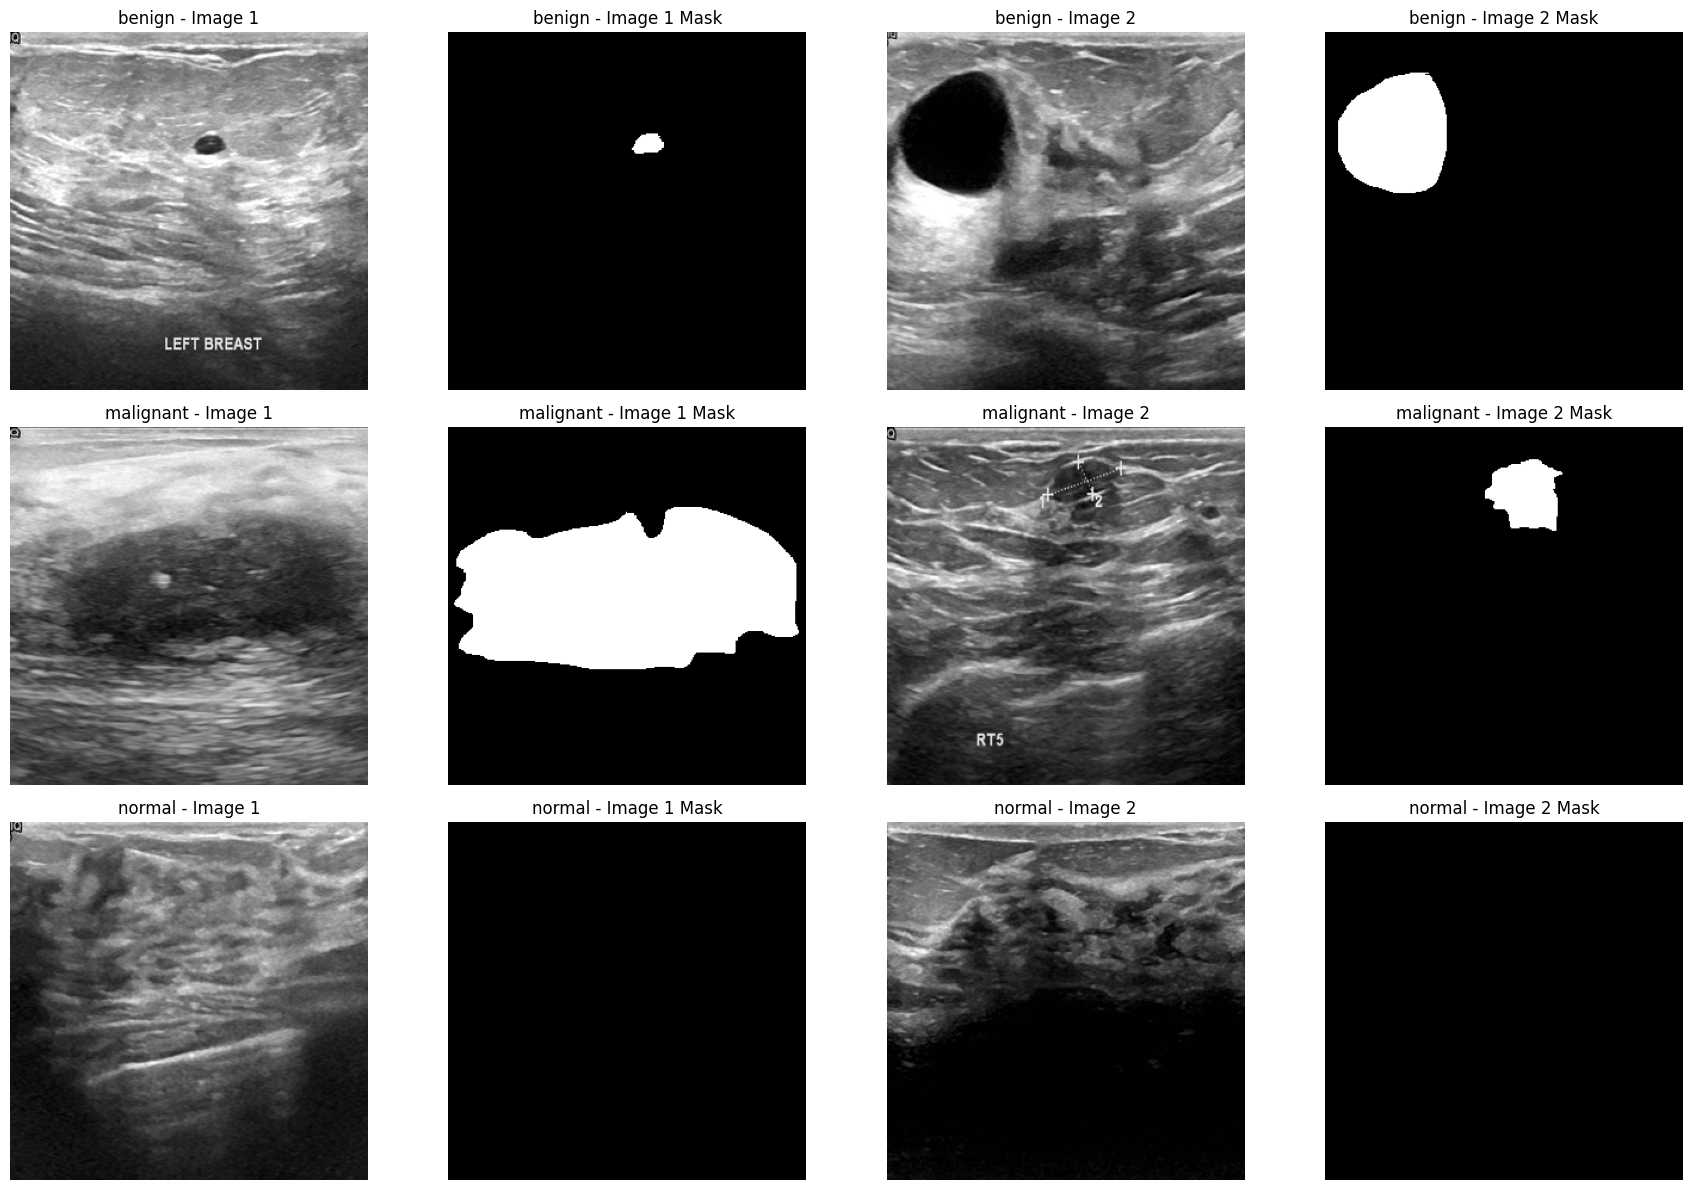

In [3]:
# Define the labels and corresponding directories
labels = ['benign', 'malignant', 'normal']
data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(18, 12))

# Desired width and height for each image
desired_width = 300  # Adjust as needed
desired_height = 300  # Adjust as needed

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)

    # Get a list of image files
    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]

    # Sort the list of image files
    image_files = sorted(image_files)

    # Loop through the first 4 image files
    for j in range(4):
        if j < len(image_files):
            # Load and resize the image
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

            # Determine the label based on whether it's an image or a mask
            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'

            # Display the image with the corresponding label
            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Set the path to the input folder containing images and masks
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Set the path to the output folder where overlayed images will be saved
output_dir = '/kaggle/working/OverlayedImages'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Function to overlay images and masks, resize if needed, and save the result
def overlay_and_save(image_path, mask_path, output_path):
    try:
        # Check if both image and mask files exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            # Open the actual image and mask image
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Ensure both images have the same color mode
            if image.mode != mask.mode:
                mask = mask.convert(image.mode)

            # Resize the images if their sizes don't match
            if image.size != mask.size:
                image = image.resize(mask.size)

            # Overlay the image with the mask
            overlayed = Image.blend(image, mask, alpha=0.5)

            # Save the overlayed image to the appropriate label folder
            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            #print(f"File not found for: {image_path} or {mask_path}. Skipping...")
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

# Iterate through the subdirectories (benign, malignant, normal)
for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                # Construct the mask file path based on the naming convention
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved to /kaggle/working/OverlayedImages directory.")

Overlayed images have been saved to /kaggle/working/OverlayedImages directory.


In [5]:
import os

# Function to count the number of files in a directory
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Set the paths to the input and output directories
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
output_dir = '/kaggle/working/OverlayedImages'

# Count the files in the input and output directories
input_counts = {}
output_counts = {}

# Count files in input directory
for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        input_counts[label] = count_files_in_directory(label_dir)

# Count files in output directory
for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

# Print file counts
print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")

File Counts Before Overlay-includes masks:
normal: 266 files
malignant: 421 files
benign: 891 files

File Counts After Overlay:
normal: 133 files
malignant: 210 files
benign: 437 files


<ipython-input-6-d399dbbd0d24>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


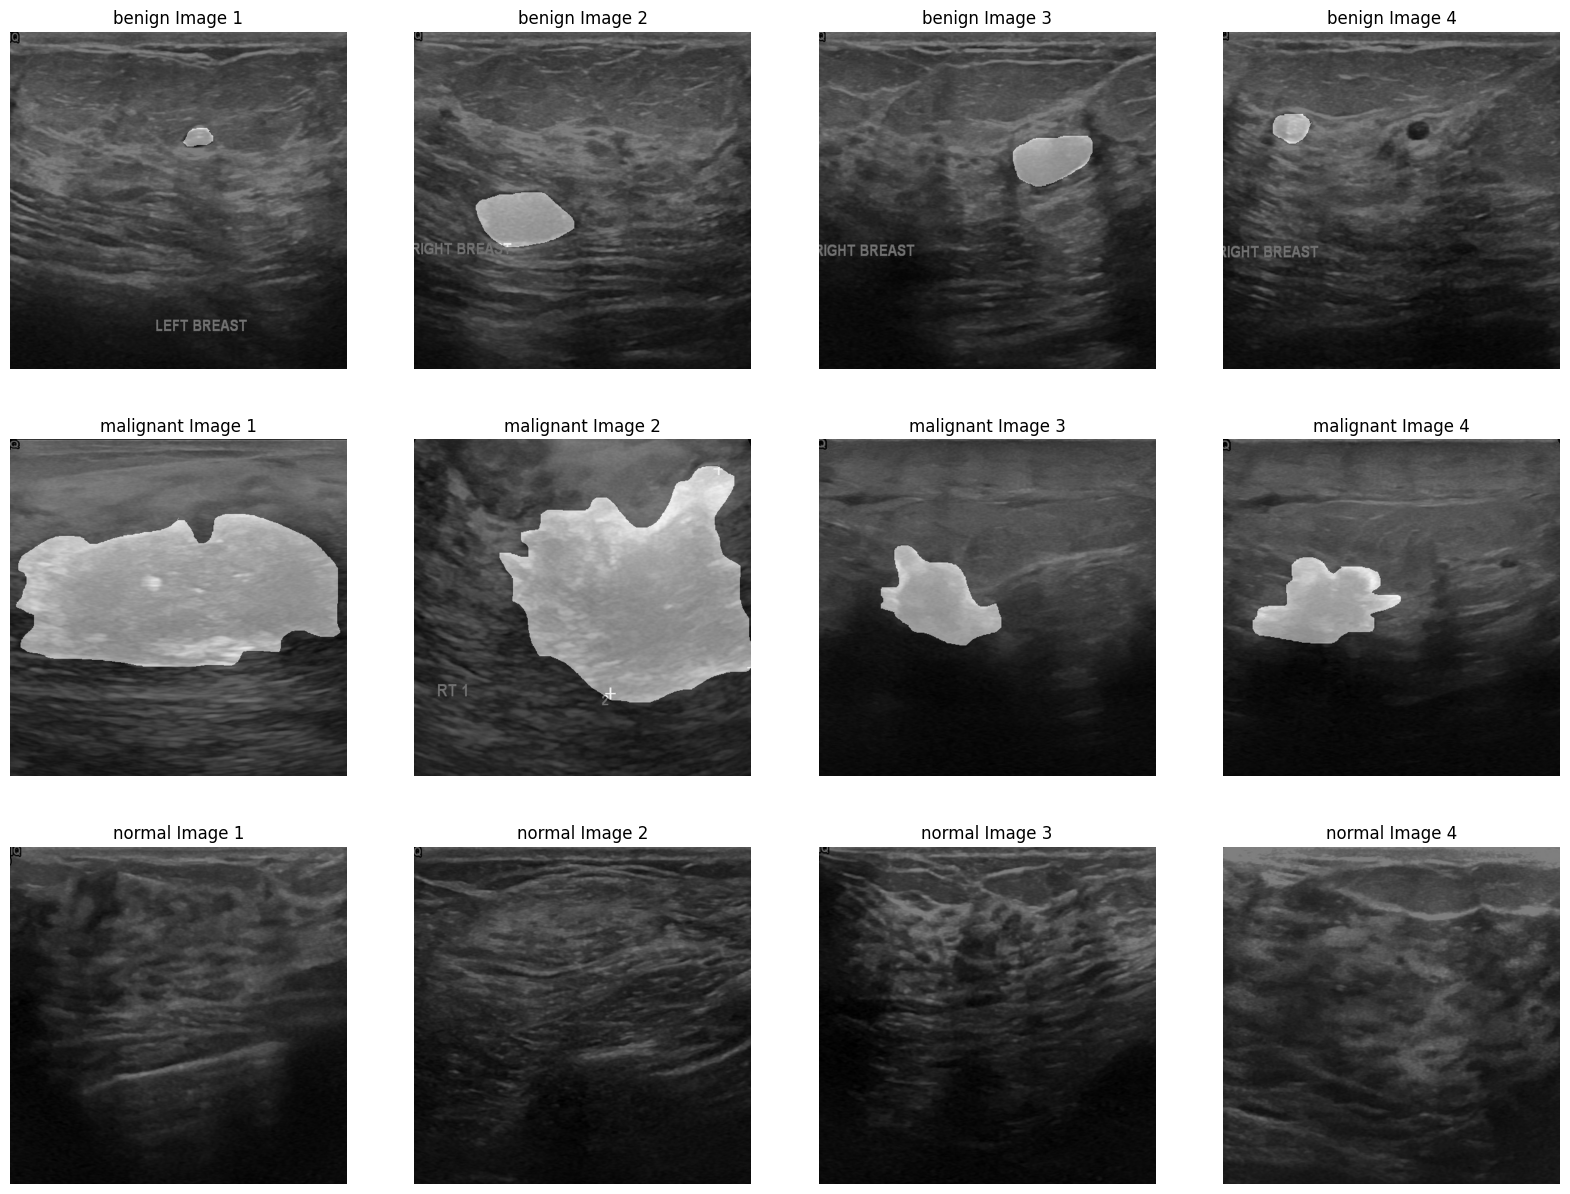

In [6]:
# Set the path to the overlayed images directory
overlayed_dir = '/kaggle/working/OverlayedImages'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

# Desired width and height for each image
desired_width = 800  # Adjust as needed
desired_height = 800  # Adjust as needed

# Loop through each label and display the first 4 images
for i, label_dir in enumerate(label_dirs):
    # Get a list of image files and sort them
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))  # Sort the images by number in parentheses

    for j, image_filename in enumerate(images[:4]):  # Display the first 4 images
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        # Resize the image to the desired width and height
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        # Display the image in the subplot
        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()

<ipython-input-7-bc6543ec352a>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
<ipython-input-7-bc6543ec352a>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
<ipython-input-7-bc6543ec352a>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)


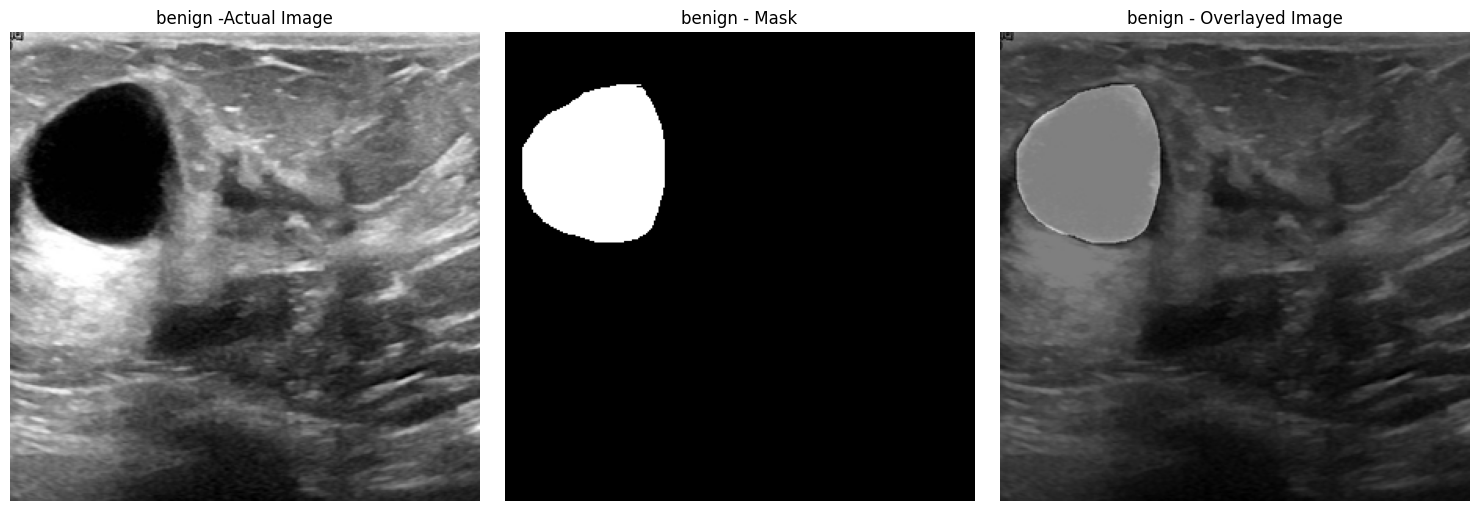

In [7]:
# Define the directory paths
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/benign'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'benign (10).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('benign -Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('benign - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

<ipython-input-8-380652ab68d7>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
<ipython-input-8-380652ab68d7>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
<ipython-input-8-380652ab68d7>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)


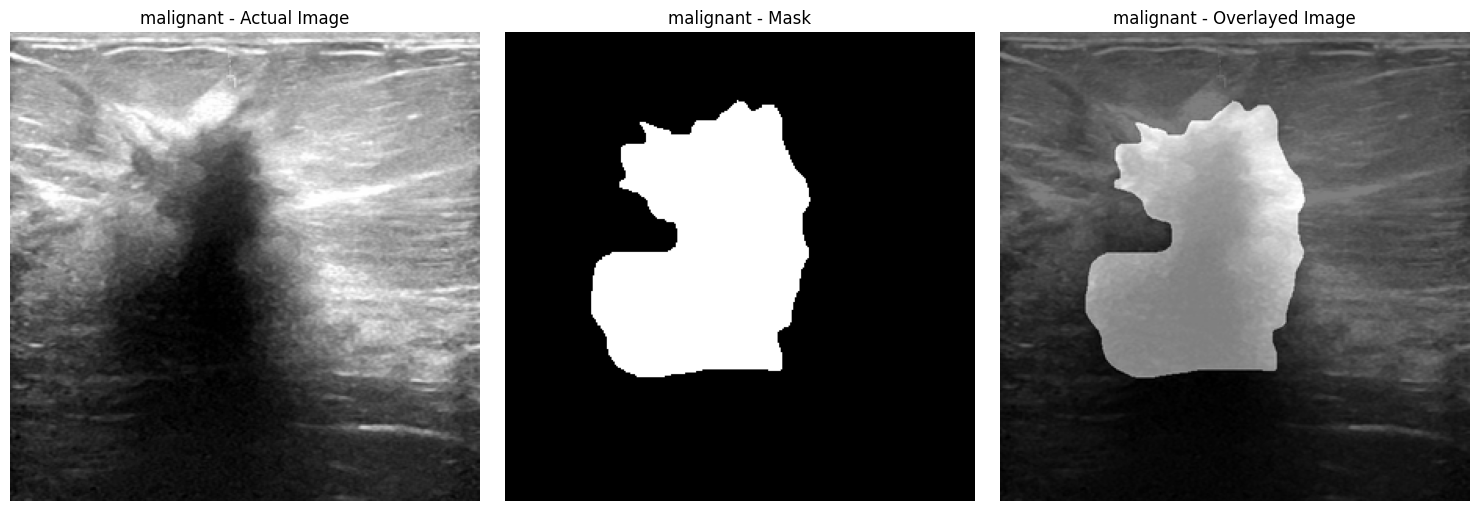

In [8]:
# Define the directory paths
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/malignant'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'malignant (103).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'malignant', image_filename)
mask_image_path = os.path.join(input_dir, 'malignant', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('malignant - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('malignant - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('malignant - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


<ipython-input-9-811a1b56ac5b>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
<ipython-input-9-811a1b56ac5b>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
<ipython-input-9-811a1b56ac5b>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)


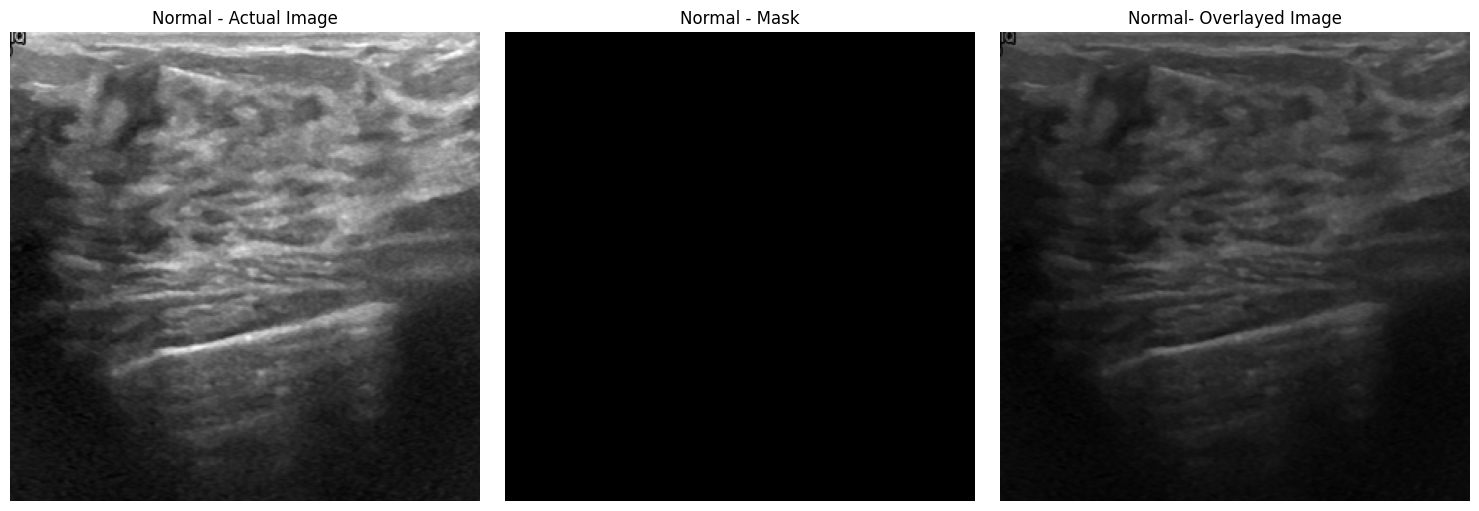

In [9]:
# Define the directory paths
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/normal'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'normal (1).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'normal', image_filename)
mask_image_path = os.path.join(input_dir, 'normal', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('Normal - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Normal - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Normal- Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Set the path to your input folder
data_dir = '/kaggle/working/OverlayedImages'

# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
none_test_data, test_data = train_test_split(data, test_size=0.20, random_state=42, stratify=data['Label'])
none_test_data, val_data = train_test_split(data, test_size=0.1, random_state=42, stratify=data['Label'])

In [11]:
print(none_test_data.shape)
print(test_data.shape)
print(val_data.shape)

(702, 2)
(156, 2)
(78, 2)


In [12]:
import numpy as np
# Set random seed for reproducibility
np.random.seed(42)

# Add a column "Labeled" to none_test_data
none_test_data['Labeled'] = np.random.choice([0, 1], size=len(none_test_data), p=[0.98, 0.02])

In [13]:
none_test_data.head(5)

,Image_Path,Label,Labeled
193,/kaggle/working/OverlayedImages/malignant/mali...,malignant,0
701,/kaggle/working/OverlayedImages/benign/benign ...,benign,0
298,/kaggle/working/OverlayedImages/malignant/mali...,malignant,0
169,/kaggle/working/OverlayedImages/malignant/mali...,malignant,0
670,/kaggle/working/OverlayedImages/benign/benign ...,benign,0


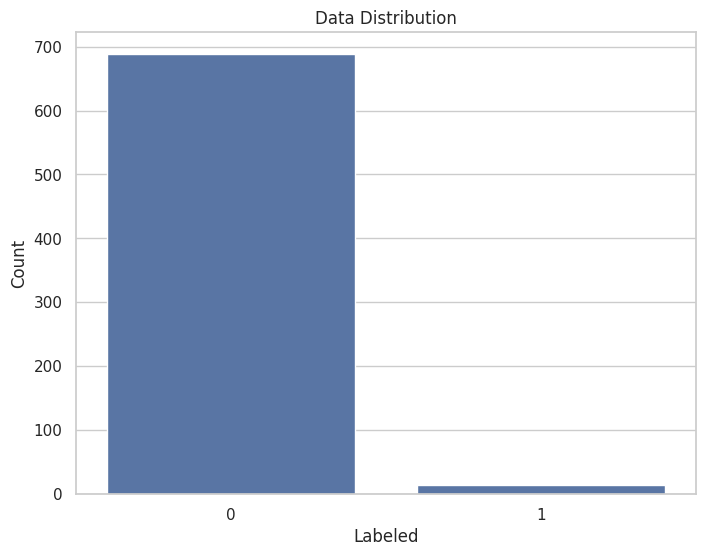

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plot
sns.set(style="whitegrid")

# Plot the distribution of the "Labeled" column
plt.figure(figsize=(8, 6))
sns.countplot(data=none_test_data, x='Labeled')
plt.title('Data Distribution')
plt.xlabel('Labeled')
plt.ylabel('Count')
plt.show()

In [15]:
counts = none_test_data['Labeled'].value_counts()
number_of_unlabeled = counts[0] if 0 in counts.index else 0
number_of_labeled = counts[1] if 1 in counts.index else 0
print(number_of_unlabeled)
print(number_of_labeled)

688
14


In [16]:
N_ROUND = 96
N_SAMPLES = 7
number_of_labeled + N_ROUND * N_SAMPLES

686

In [17]:
def get_unlabeled_data(dataframe):
    indices = dataframe[dataframe['Labeled'] == 0].index.tolist()
    entries = dataframe[dataframe['Labeled'] == 0]
    return indices, entries

In [18]:
def get_labeled_data(dataframe):
    indices = dataframe[dataframe['Labeled'] == 1].index.tolist()
    entries = dataframe[dataframe['Labeled'] == 1]
    return indices, entries

In [19]:
IMG_SIZE = 256
BATCH_SIZE = 32
N_EPOCHS = 30
DESIRED_ACC = 0.97

def build_model(input_shape = (IMG_SIZE, IMG_SIZE, 3)):
    input_layer = Input(shape = input_shape)

    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers:
        if "BatchNormalization" in str(layer):
            layer.trainable = True
            layer._per_input_updates = {}
    x = base_model(input_layer)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs = input_layer, outputs = output)
    return model

def train(labeled_data, validation = True):

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_dataframe(
        labeled_data,
        x_col = "Image_Path",
        y_col = "Label",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
    )

    if validation:
        val_generator = train_datagen.flow_from_dataframe(
            val_data,
            x_col = "Image_Path",
            y_col = "Label",
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
        )

    model = build_model()

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # checkpoint = ModelCheckpoint("best_weights.keras", monitor='loss', verbose=1, save_best_only=True, mode='min')

    if validation:
        early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4, restore_best_weights=True)
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            callbacks = [early_stopping],
            epochs=N_EPOCHS
        )
    else:
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // BATCH_SIZE,
            epochs=N_EPOCHS
        )

    return model

def predict(model, dataframe):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    data_generator = datagen.flow_from_dataframe(
        dataframe,
        x_col = "Image_Path",
        y_col = "Label",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle = False
    )

    preds  = model.predict(data_generator)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = data_generator.labels
    accuracy = accuracy_score(true_classes, predicted_classes)
    return preds, accuracy



In [20]:
def random_sampling(preds, indices):
    # Get the total number of samples
    total_samples = preds.shape[0]

    # Generate random indices for sampling without replacement
    random_indices = np.random.choice(total_samples, size=N_SAMPLES, replace=False)

    # Get the actual dataframe indices for the randomly selected samples
    actual_indices = [indices[i] for i in random_indices]

    return actual_indices

def least_confidence_sampling(preds, indices):
    confidence_scores = np.max(preds, axis=1)  # Highest probability for each sample
    least_confident_indices = np.argsort(confidence_scores)[:N_SAMPLES]  # Indices of N_SAMPLES least confident predictions

    actual_indices = [indices[i] for i in least_confident_indices]  # Map to actual dataframe indices
    return actual_indices


def margin_of_confidence_sampling(preds, indices):
#     Sort the predictions in descending order
    sorted_preds = np.sort(preds, axis=1)[:, ::-1]

    # Calculate margins: difference between the two highest probabilities
    margins = sorted_preds[:, 0] - sorted_preds[:, 1]

    # Find the indices of the N_SAMPLES smallest margins
    selected_indices = np.argsort(margins)[:N_SAMPLES]

    # Get the actual dataframe indices for these selected samples
    actual_indices = [indices[i] for i in selected_indices]

      # Calculate margin of confidence
#     margins = preds.max(axis=1) - np.partition(preds, -2, axis=1)[:,-2]
#     # Identify N_SAMPLES samples with the smallest margins
#     selected_indices = np.argsort(margins)[:N_SAMPLES]
#     actual_indices = [indices[i] for i in selected_indices]
    return actual_indices


def ratio_sampling(preds, indices):
     # Sort the probabilities for each prediction
    sorted_preds = np.sort(preds, axis=1)

    # Calculate the ratio of the top two predictions
    ratios = sorted_preds[:, -2] / sorted_preds[:, -1]

    # Select the indices of the samples with the smallest ratios
    selected_indices = np.argsort(ratios)[:N_SAMPLES]

    # Map back to the original indices in the dataframe
    actual_indices = [indices[i] for i in selected_indices]

    return actual_indices

def entropy_based_sampling(preds, indices):
    # Calculate entropy for each prediction
    entropy = -np.sum(preds * np.log(preds + 1e-10), axis=1)  # Adding a small epsilon to avoid log(0)

    # Find the indices of the N_SAMPLES highest entropy samples
    selected_indices = np.argsort(entropy)[-N_SAMPLES:]

    # Get the actual dataframe indices for these selected samples
    actual_indices = [indices[i] for i in selected_indices]

    return actual_indices

In [21]:
def active_learning(none_test_data, test_data, strategy = "RandomSampling"):
    _, labeled_data = get_labeled_data(none_test_data)

    print("*** Round 0 training...")
    model = train(labeled_data)

    preds, accuracy = predict(model, test_data)
    print(f"==> Round 0 testing accuracy: {accuracy}")
    print()

    round_acc = {}
    round_acc[0] = accuracy
    return_data_frame = None
    return_model = None
    achieve = False

    for rd in range(1, N_ROUND + 1):
        print(f"*** Round {rd} training...")

        indices, unlabeled_data = get_unlabeled_data(none_test_data)
        preds, acc = predict(model, unlabeled_data)

        if (strategy == "RandomSampling"):
            print("** RandomSampling ... ")
            actual_indices = random_sampling(preds, indices)
        if (strategy == "LeastConfidenceSampling"):
            print("** LeastConfidenceSampling ... ")
            actual_indices = least_confidence_sampling(preds, indices)
        elif (strategy == "MarginSampling"):
            print("** MarginSampling ... ")
            actual_indices = margin_of_confidence_sampling(preds, indices)
        elif (strategy == "RatioSampling"):
            print("** RatioSampling ... ")
            actual_indices = ratio_sampling(preds, indices)
        elif (strategy == "EntropySampling"):
            print("** EntropySampling ... ")
            actual_indices = entropy_based_sampling(preds, indices)

        for idx in actual_indices:
            none_test_data.loc[idx, 'Labeled'] = 1  # Update the 'Labeled' status

        _, combined_labeled_data = get_labeled_data(none_test_data)
        # Train and predict
        model = train(combined_labeled_data)
        preds, accuracy = predict(model, test_data)

        print(f"==> Round {rd} testing accuracy: {accuracy}")
        if (not achieve and accuracy >= DESIRED_ACC):
          print("#### Active learning reach desire accuracy.")
          return_data_frame = none_test_data
          return_model = model
          achieve = True

        print()
        round_acc[rd] = accuracy
    return round_acc, return_model, return_data_frame

In [ ]:
R_round_acc, R_model, R_final_data = active_learning(none_test_data, test_data, strategy = "RandomSampling")

In [ ]:
LCS_round_acc, LCS_model, LCS_final_data = active_learning(none_test_data, test_data, strategy = "LeastConfidenceSampling")

*** Round 0 training...
Found 14 validated image filenames belonging to 3 classes.
Found 78 validated image filenames belonging to 3 classes.
171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/30


In [ ]:
MCS_round_acc, MCS_model, MCS_final_data = active_learning(none_test_data, test_data, strategy = "MarginSampling")

*** Round 0 training...
Found 14 validated image filenames belonging to 3 classes.
Found 78 validated image filenames belonging to 3 classes.
171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/30
1/1 [==============================] - 46s 46s/step - loss: 1.1102 - accuracy: 0.5000 - val_loss: 0.7608 - val_accuracy: 0.6410
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 0.2742 - accuracy: 0.9286 - val_loss: 1.5935 - val_accuracy: 0.4615
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 0.0465 - accuracy: 1.0000 - val_loss: 3.2412 - val_accuracy: 0.3974
Epoch 4/30
1/1 [==============================] - 1s 1s/step - loss: 0.1815 - accuracy: 0.8571 - val_loss: 1.8879 - val_accuracy: 0.4615
Epoch 5/30
1/1 [==============================] - 2s 2s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.0375 - val_accuracy: 0.6923
Epoch 5: early stopping
Found 156 validated image filenames belonging to 3 classes.
5/5 [===============

In [ ]:
RS_round_acc, RS_model, RS_final_data = active_learning(none_test_data, test_data, strategy = "RatioSampling")

In [ ]:
ES_round_acc, ES_model, ES_final_data = active_learning(none_test_data, test_data, strategy = "EntropySampling")

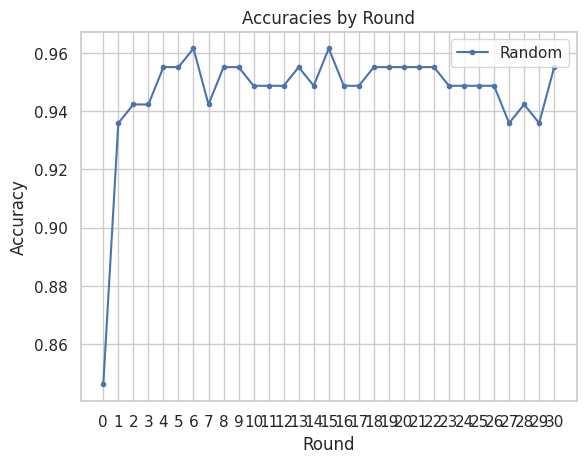

In [ ]:
import matplotlib.pyplot as plt

rounds = list(R_round_acc.keys())
accuracies0 = list(R_round_acc.values())
accuracies1 = list(LCS_round_acc.values())
accuracies2 = list(MCS_round_acc.values())
accuracies3 = list(RS_round_acc.values())
accuracies4 = list(ES_round_acc.values())

plt.plot(rounds, accuracies0, marker='.', label='Random')
plt.plot(rounds, accuracies1, marker='o', label='Least Confidence')
plt.plot(rounds, accuracies2, marker='s', label='Margin of Confidence')
plt.plot(rounds, accuracies3, marker='p', label='Ratio')
plt.plot(rounds, accuracies4, marker='h', label='Entropy-based')

plt.title('Accuracies by Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(len(rounds)))
plt.legend()
plt.show()
